In [1]:
%load_ext autoreload
%autoreload 2
import glob
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
from functools import partial
import pickle
import lightning as L
import copy

import sys
sys.path.append("../..")
from dnn.ak_sample_loader import *
from dnn.torch_dataset import *
from dnn.training import *
from dnn.validation import *
from dnn.fit import fitCruijff, CruijffFitResult
from dnn.train_lightning import FastDNNModule
from dnn.model import ParametrizedDNN, loss_mse_basic_ratio_constrained

In [2]:
base_checkpoint_path = "/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v12c/lightning_logs/version_15"

In [3]:
feature_version = "feat-v2"
device = "cpu"

input_test_perEnergy = {
    10 : '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_10.pkl',
    100 : "/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_100.pkl",
 200 : '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_200.pkl',
 300 : '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_300.pkl',
 400: '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_400.pkl',
 600 : '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_600.pkl'}
input_test_perEnergy = {energy : AkSampleLoader.loadFromPickle(inputFile) for energy, inputFile in input_test_perEnergy.items()}


energies_PU = [10, 20, 50, 100, 200, 500, 600]
input_PU_perEnergy = {energy : AkSampleLoader.loadFromPickle(f"/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_PU/v1/{energy}.pkl") for energy in energies_PU}
input_PU_associated_perEnergy = {energy : AkSampleLoader.loadFromPickle(f"/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_PU/v1/{energy}_assoc.pkl") for energy in energies_PU}


datasets_perEnergy = {energy : RegressionDataset(input, feature_version, device=device) for energy, input in input_test_perEnergy.items()}
datasets_PU = {energy : RegressionDataset(input, feature_version, device=device) for energy, input in input_PU_perEnergy.items()}
datasets_PU_associated = {energy : RegressionDataset(input, feature_version, device=device) for energy, input in input_PU_associated_perEnergy.items()}


In [35]:
datasets_PU[600]

In [34]:
module.model()

ParametrizedDNN(
  (model): Sequential(
    (0): Linear(in_features=17, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [5]:
loss_constrained_v1 = partial(loss_mse_basic_ratio_constrained, negative_regularization_coef=0.1, minFractionOfRawEnergy=0.9, minFractionOfRawEnergy_regCoeff=5)
module = FastDNNModule.load_from_checkpoint(
    base_checkpoint_path+"/checkpoints/epoch=41-step=6888.ckpt",
    loss_fn=loss_constrained_v1, getResultsFromModel_fct=getResultsFromModel_basicLoss, fixedEnergies=datasets_perEnergy, fixedEnergies_PU=datasets_PU, model=ParametrizedDNN(17, hidden_size=10, num_layers=5)
)
trainer = L.Trainer(devices=[0])

{'nfeat': 17, 'hidden_size': 10, 'num_layers': 5, 'negative_regularization_coef': 10.0, 'minFractionOfRawEnergy': 0.9, 'minFractionOfRawEnergy_regCoeff': 5.0, 'model.hidden_size': 10, 'model.num_layers': 5, 'lr': 0.001, 'batch_size': 512}
"batch_size":                      512
"hidden_size":                     10
"lr":                              0.001
"minFractionOfRawEnergy":          0.9
"minFractionOfRawEnergy_regCoeff": 5.0
"model.hidden_size":               10
"model.num_layers":                5
"negative_regularization_coef":    10.0
"nfeat":                           17
"num_layers":                      5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
for h_d in module.hists_fixedEnergy.values():
    for h in h_d.values():
        h.reset()
for h_d in module.hists_fixedEnergy_PU.values():
    for h in h_d.values():
        h.reset()

In [7]:
trainer.test(model=module, dataloaders=[makeDataLoader(dataset, batch_size=10000) for dataset in datasets_perEnergy.values()] + [makeDataLoader(dataset, batch_size=10000) for dataset in datasets_PU.values()])
hists_perE = copy.deepcopy(module.hists_fixedEnergy)
hists_perE_PU = copy.deepcopy(module.hists_fixedEnergy_PU)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


Cruijff fit failed
Weights sum to zero, can't be normalized


/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale


Cruijff fit failed
Weights sum to zero, can't be normalized


/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale


Cruijff fit failed
Weights sum to zero, can't be normalized
Cruijff fit failed
Weights sum to zero, can't be normalized


/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale


Cruijff fit failed
Weights sum to zero, can't be normalized
Cruijff fit failed
Weights sum to zero, can't be normalized
Cruijff fit failed
Weights sum to zero, can't be normalized


In [8]:
for h_d in module.hists_fixedEnergy.values():
    for h in h_d.values():
        h.reset()
for h_d in module.hists_fixedEnergy_PU.values():
    for h in h_d.values():
        h.reset()

In [9]:
trainer.test(model=module, dataloaders=[makeDataLoader(dataset, batch_size=10000) for dataset in datasets_perEnergy.values()] + [makeDataLoader(dataset, batch_size=10000) for dataset in datasets_PU_associated.values()])
hists_perE_PU_associated = copy.deepcopy(module.hists_fixedEnergy_PU)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


/grid_mnt/data_cms_upgrade/cuisset/conda/envs/ticlRegression-gpu/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


Cruijff fit failed
Optimal parameters not found: Number of calls to function has reached maxfev = 500000.


/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlR

In [10]:
# def loadFromPkl(fileName):
#     with open(base_checkpoint_path + "/" + fileName, "rb") as f:
#         return pickle.load(f)
# hists_perE = {energy : loadFromPkl(f"hists_{energy}.pkl") for energy in input_test_perEnergy.keys()}
# hists_perE_PU = {energy : loadFromPkl(f"hists_{energy}_PU.pkl") for energy in [10, 20, 50, 100, 200, 500]}

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

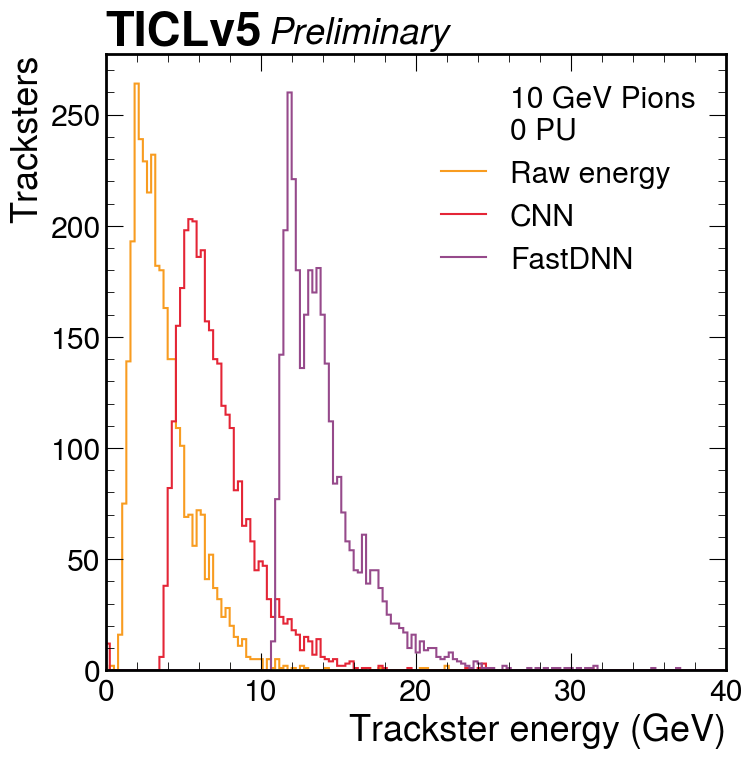

In [11]:
hists = hists_perE[10]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="10 GeV Pions\n0 PU")
hep.histplot([hists["h_reco"], hists["h_cnn"], hists["h_pred"]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 40)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

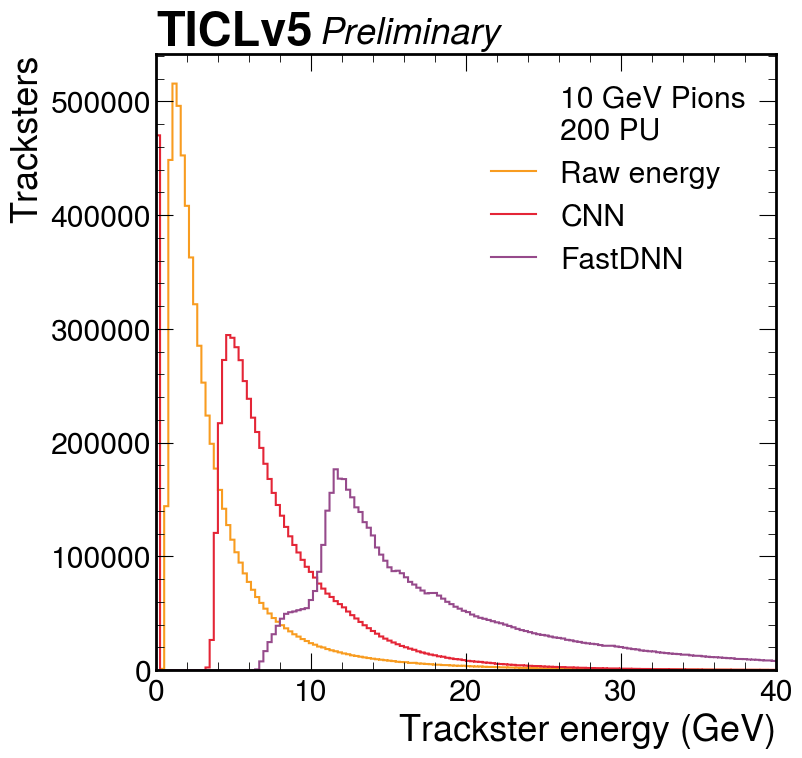

In [12]:
hists = hists_perE_PU[10]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="10 GeV Pions\n200 PU")
hep.histplot([hists["h_reco"], hists["h_cnn"], hists["h_pred"]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 40)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

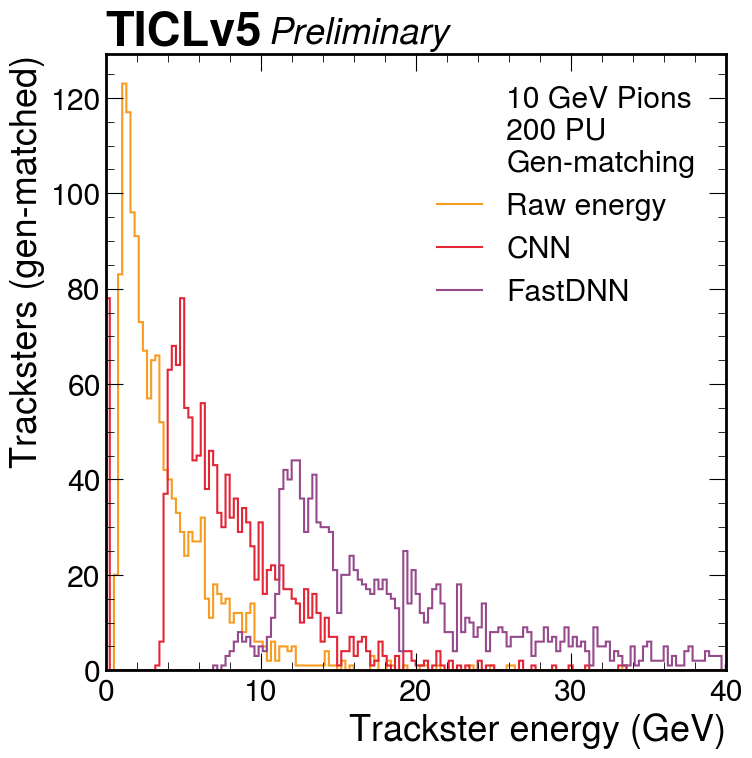

In [13]:
hists = hists_perE_PU_associated[10]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="10 GeV Pions\n200 PU\nGen-matching")
hep.histplot([hists["h_reco"], hists["h_cnn"], hists["h_pred"]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters (gen-matched)")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 40)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

### 100 GeV

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

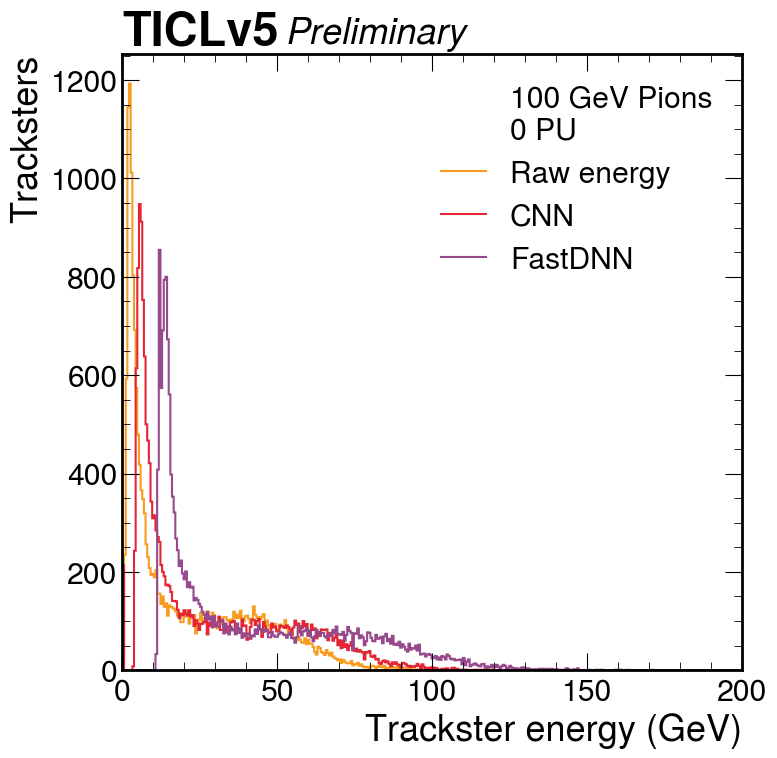

In [14]:
hists = hists_perE[100]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="100 GeV Pions\n0 PU")
hep.histplot([hists["h_reco"][::hist.rebin(2)], hists["h_cnn"][::hist.rebin(2)], hists["h_pred"][::hist.rebin(2)]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 200)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

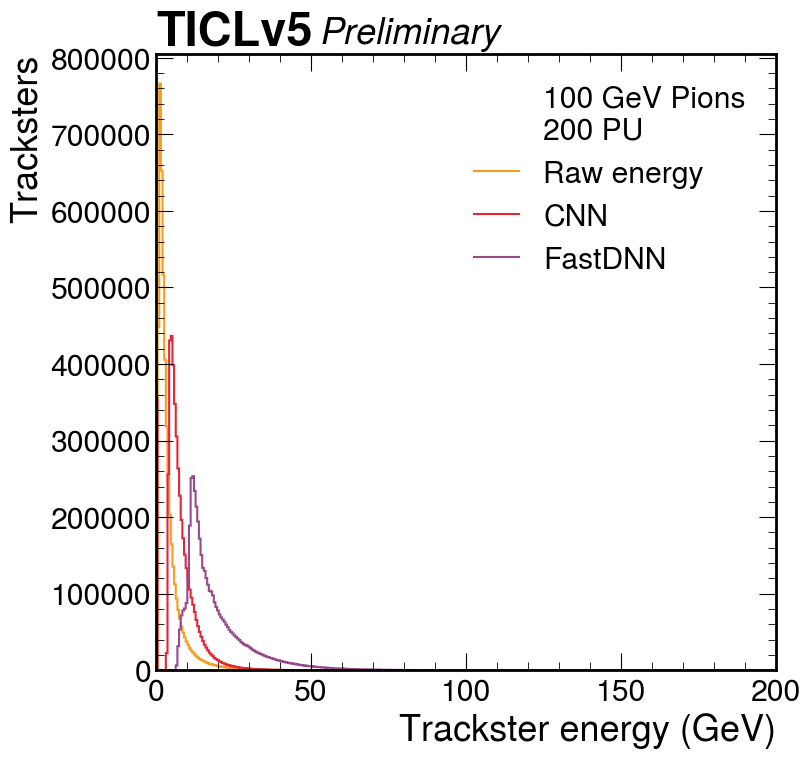

In [15]:
hists = hists_perE_PU[100]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="100 GeV Pions\n200 PU")
hep.histplot([hists["h_reco"][::hist.rebin(2)], hists["h_cnn"][::hist.rebin(2)], hists["h_pred"][::hist.rebin(2)]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 200)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

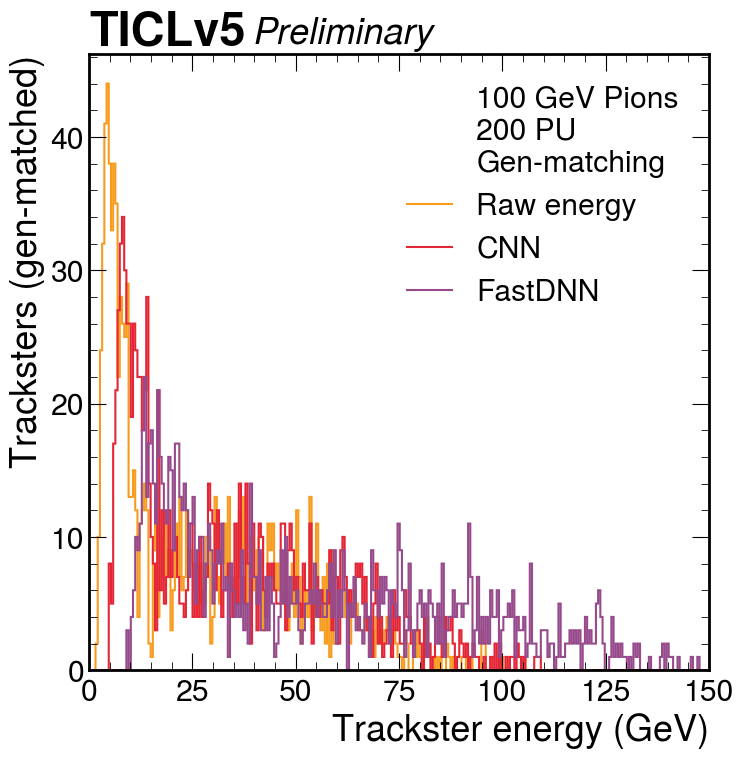

In [16]:
hists = hists_perE_PU_associated[100]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="100 GeV Pions\n200 PU\nGen-matching")
hep.histplot([hists["h_reco"][::hist.rebin(2)], hists["h_cnn"][::hist.rebin(2)], hists["h_pred"][::hist.rebin(2)]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters (gen-matched)")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 150)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

### 600 GeV

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

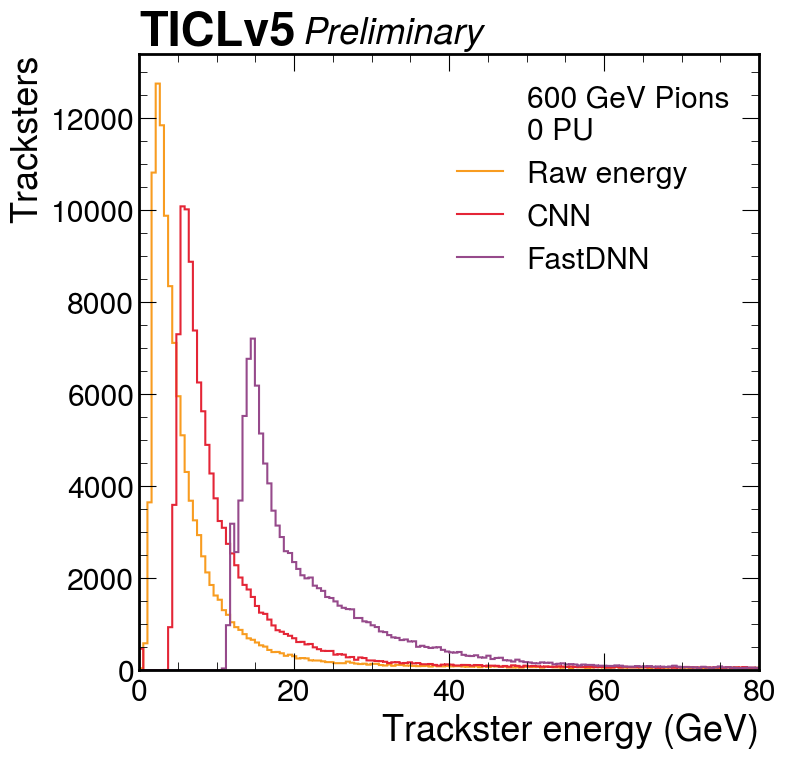

In [17]:
hists = hists_perE[600]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="600 GeV Pions\n0 PU")
hep.histplot([hists["h_reco"][::hist.rebin(2)], hists["h_cnn"][::hist.rebin(2)], hists["h_pred"][::hist.rebin(2)]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 80)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

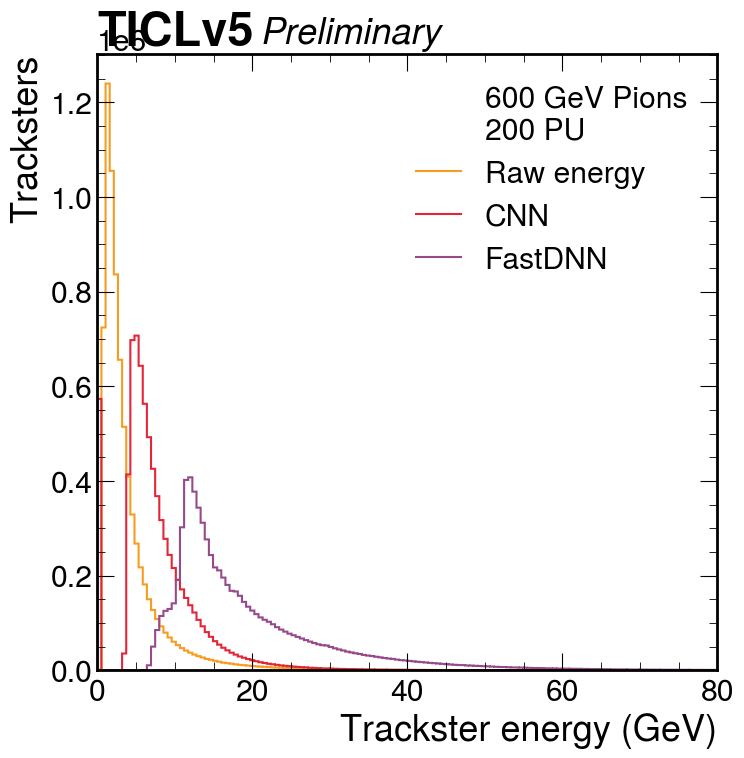

In [18]:
hists = hists_perE_PU[600]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="600 GeV Pions\n200 PU")
hep.histplot([hists["h_reco"][::hist.rebin(2)], hists["h_cnn"][::hist.rebin(2)], hists["h_pred"][::hist.rebin(2)]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 80)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

(exptext: Custom Text(0.0, 1, 'TICLv5'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

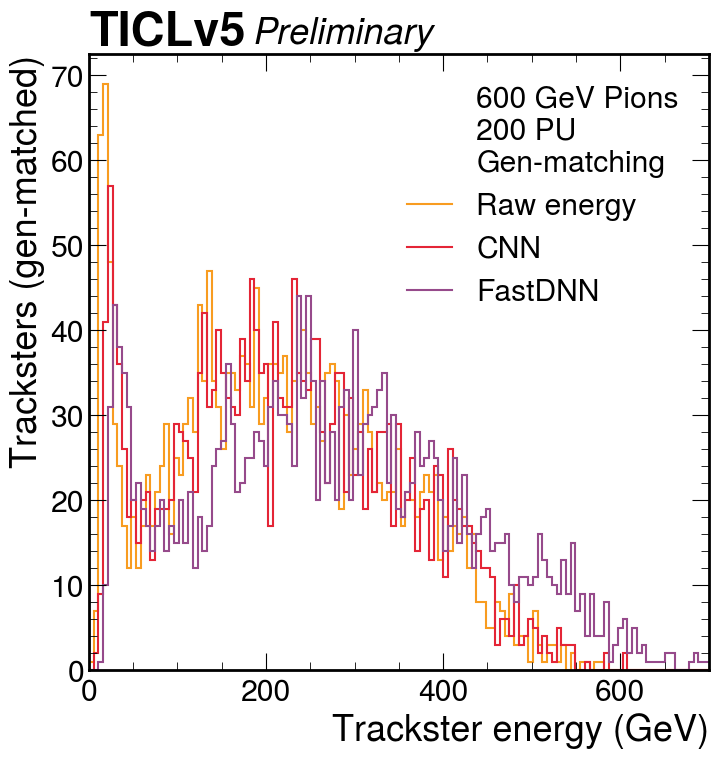

In [19]:
hists = hists_perE_PU_associated[600]
plt.figure(figsize=(8, 8))
plt.plot([], [], ' ', label="600 GeV Pions\n200 PU\nGen-matching")
rebin_cnt  =20
hep.histplot([hists["h_reco"][::hist.rebin(rebin_cnt)], hists["h_cnn"][::hist.rebin(rebin_cnt)], hists["h_pred"][::hist.rebin(rebin_cnt)]], label=["Raw energy", "CNN", "FastDNN"], yerr=False,
             flow="none")
plt.ylabel("Tracksters (gen-matched)")
plt.xlabel("Trackster energy (GeV)")
plt.xlim(0, 700)

plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")

## Scatter

<Axes: xlabel='Raw trackster energy (GeV)', ylabel='FastDNN trackster predicted energy (GeV)'>

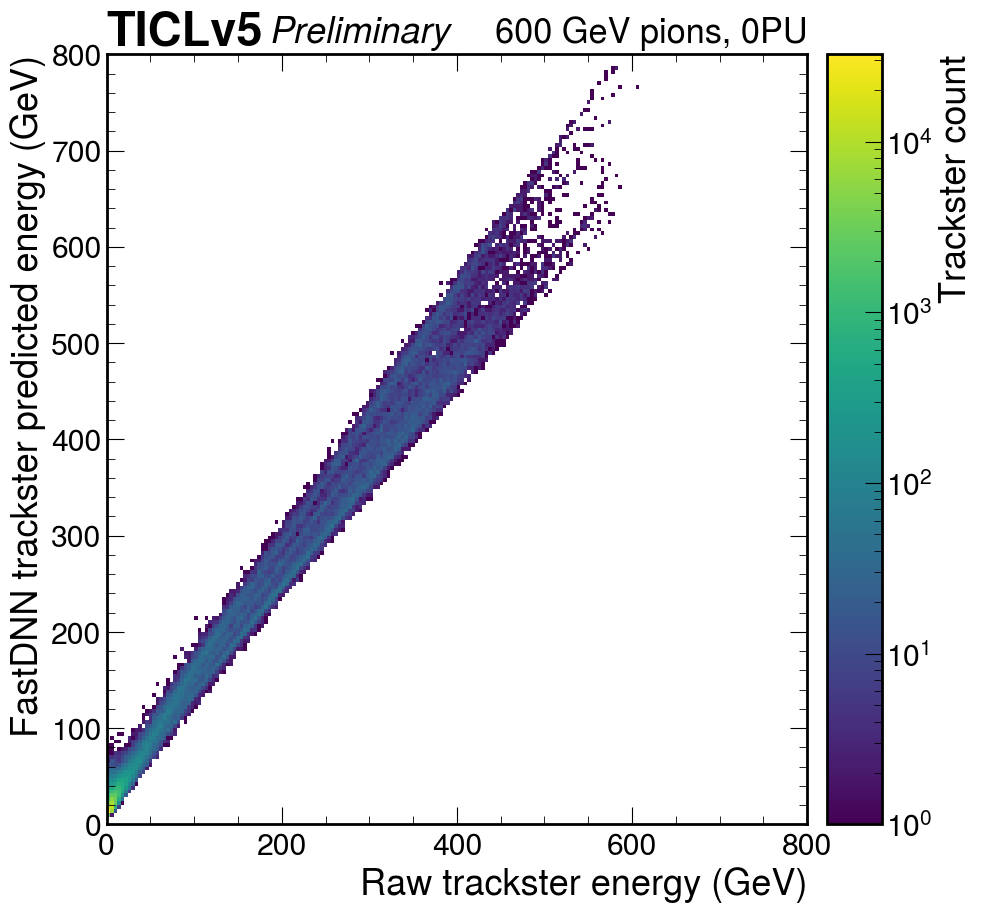

In [20]:
hists = hists_perE[600]
plt.figure()
cbar = hep.hist2dplot(hists["h_pred_vs_reco"], norm=colors.LogNorm(vmin=1, vmax=hists["h_pred_vs_reco"].values().max()), flow="none").cbar
cbar.set_label("Trackster count")
plt.ylabel("FastDNN trackster predicted energy (GeV)")
plt.xlabel("Raw trackster energy (GeV)")
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("600 GeV pions, 0PU")

Text(10, 270, 'Gen-matched tracksters')

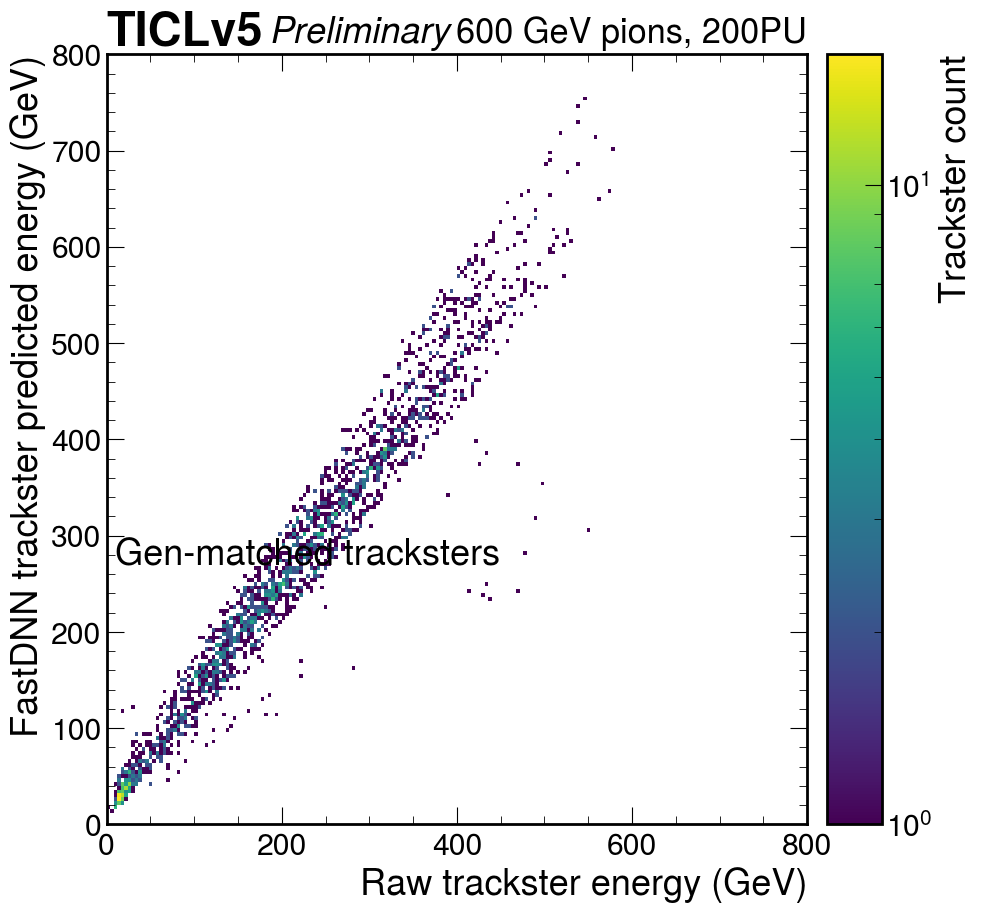

In [21]:
hists = hists_perE_PU_associated[600]
plt.figure()
cbar = hep.hist2dplot(hists["h_pred_vs_reco"], norm=colors.LogNorm(vmin=1, vmax=hists["h_pred_vs_reco"].values().max()), flow="none").cbar
cbar.set_label("Trackster count")
plt.ylabel("FastDNN trackster predicted energy (GeV)")
plt.xlabel("Raw trackster energy (GeV)")
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("600 GeV pions, 200PU")
plt.text(10, 270, "Gen-matched tracksters")

<Axes: xlabel='Raw trackster energy (GeV)', ylabel='CNN trackster predicted energy (GeV)'>

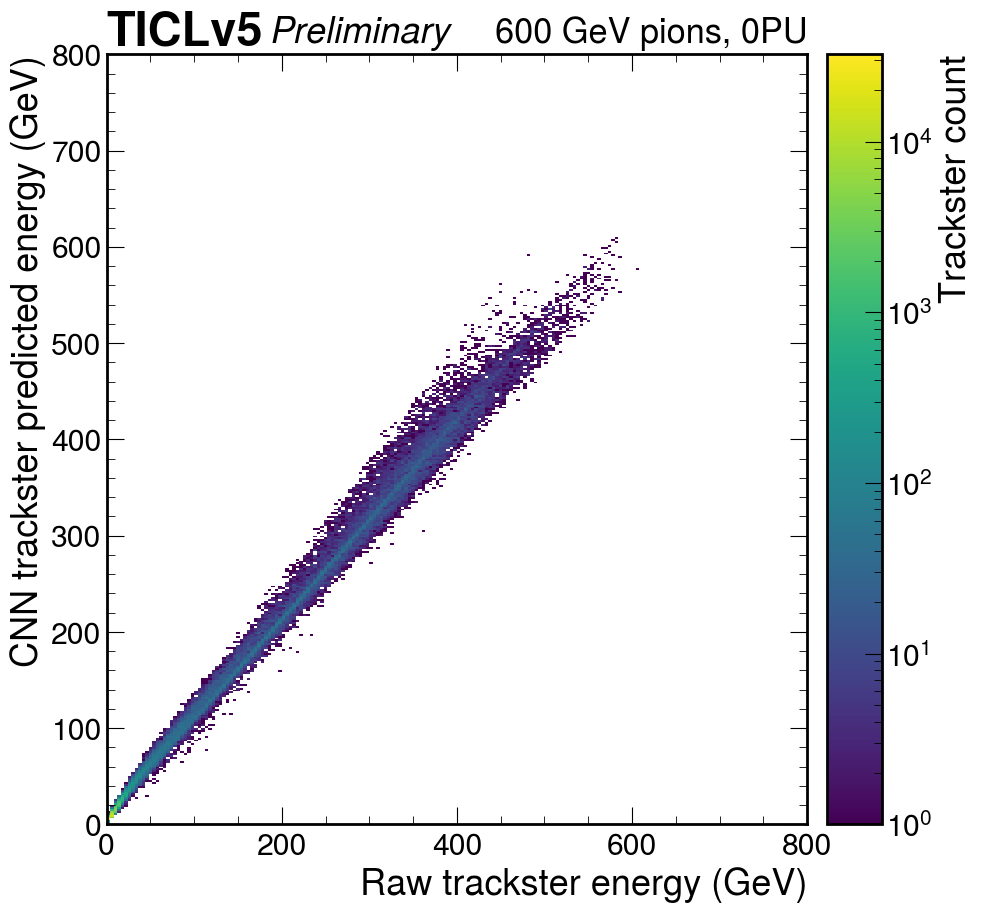

In [22]:
hists = hists_perE[600]
plt.figure()
cbar = hep.hist2dplot(hists["h_pred_vs_reco_vs_cnn"][{"pred_energy":hist.sum}], norm=colors.LogNorm(vmin=1, vmax=hists["h_pred_vs_reco"].values().max()), flow="none").cbar
cbar.set_label("Trackster count")
plt.ylabel("CNN trackster predicted energy (GeV)")
plt.xlabel("Raw trackster energy (GeV)")
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("600 GeV pions, 0PU")

Text(10, 270, 'Gen-matched tracksters')

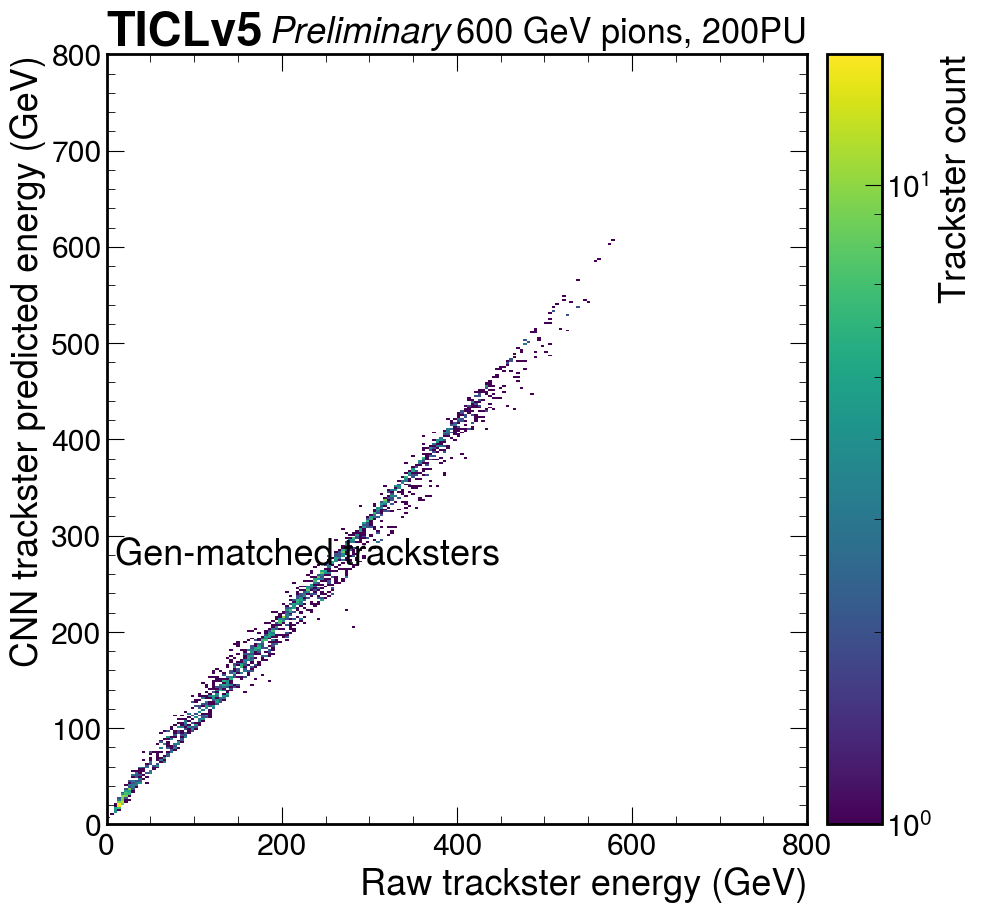

In [23]:
hists = hists_perE_PU_associated[600]
plt.figure()
cbar = hep.hist2dplot(hists["h_pred_vs_reco_vs_cnn"][{"pred_energy":hist.sum}], norm=colors.LogNorm(vmin=1, vmax=hists["h_pred_vs_reco"].values().max()), flow="none").cbar
cbar.set_label("Trackster count")
plt.ylabel("CNN trackster predicted energy (GeV)")
plt.xlabel("Raw trackster energy (GeV)")
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("600 GeV pions, 200PU")
plt.text(10, 270, "Gen-matched tracksters")

## Full energies

In [24]:
hists["h_reco_tot"]

Hist(Regular(3000, 0, 800, name='reco_energy_tot', label='Total trackster raw energy (GeV)'), storage=Double()) # Sum: 1835.0

<Axes: xlabel='Sum of trackster energy in endcap (GeV)', ylabel='Events'>

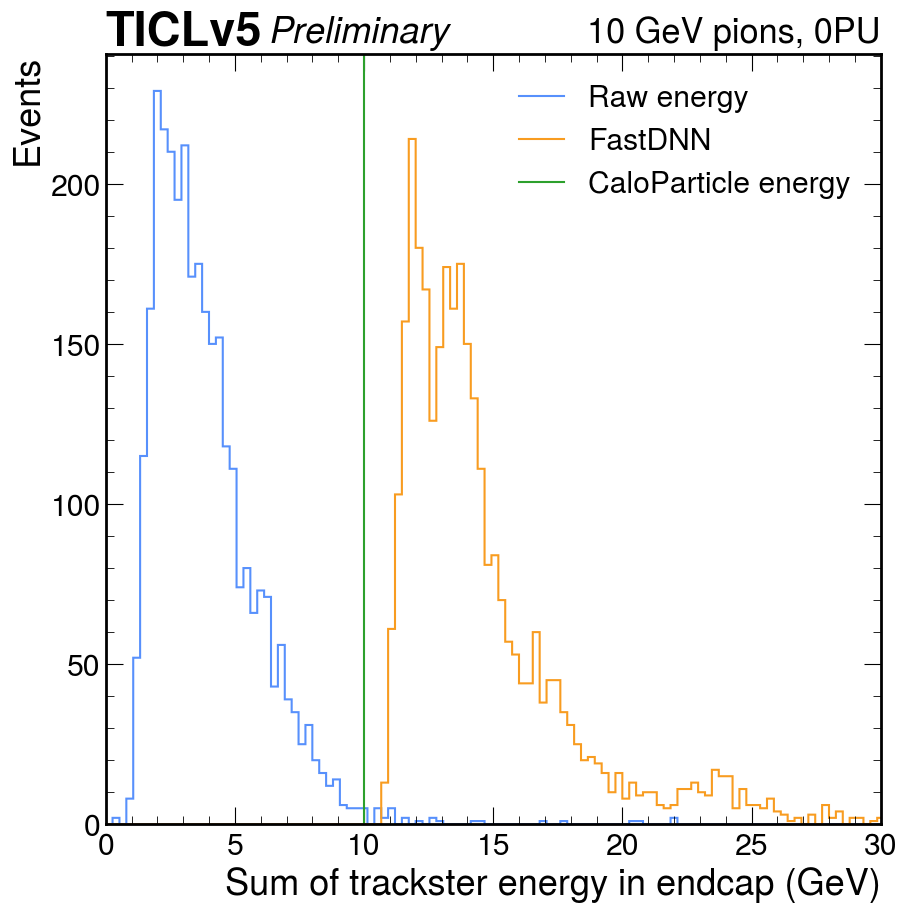

In [36]:
hists = hists_perE[10]
plt.figure()
rebin_cnt = 1
hep.histplot([hists["h_reco_tot"][::hist.rebin(rebin_cnt)], hists["h_pred_tot"][::hist.rebin(rebin_cnt)]],
    yerr=False, label=["Raw energy", "FastDNN"], flow="none")

plt.axvline(x=10, label="CaloParticle energy", color="tab:green")

def plotFit(h:hist.Hist):
    fitRes = fitCruijff(h)
    params = fitRes.params
    x_plotFct = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1],500)
    plt.plot(x_plotFct,cruijff(x_plotFct,*params.makeTuple()), 
        label=f"Cruijff fit\n$\sigma={(params.sigmaL+params.sigmaR)/2:.3f}$, $\mu={params.m:.3f}$, " +r"$\frac{\sigma}{\mu}=" + f"{(params.sigmaL+params.sigmaR)/(2*params.m):.3f}$")

#plotFit(hists["h_pred_tot"][::hist.rebin(5)])

plt.ylabel("Events")
plt.xlabel("Sum of trackster energy in endcap (GeV)")

plt.xlim(left=0, right=30)
plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("10 GeV pions, 0PU")

<Axes: xlabel='Sum of energy of gen-matched tracksters (GeV)', ylabel='Events'>

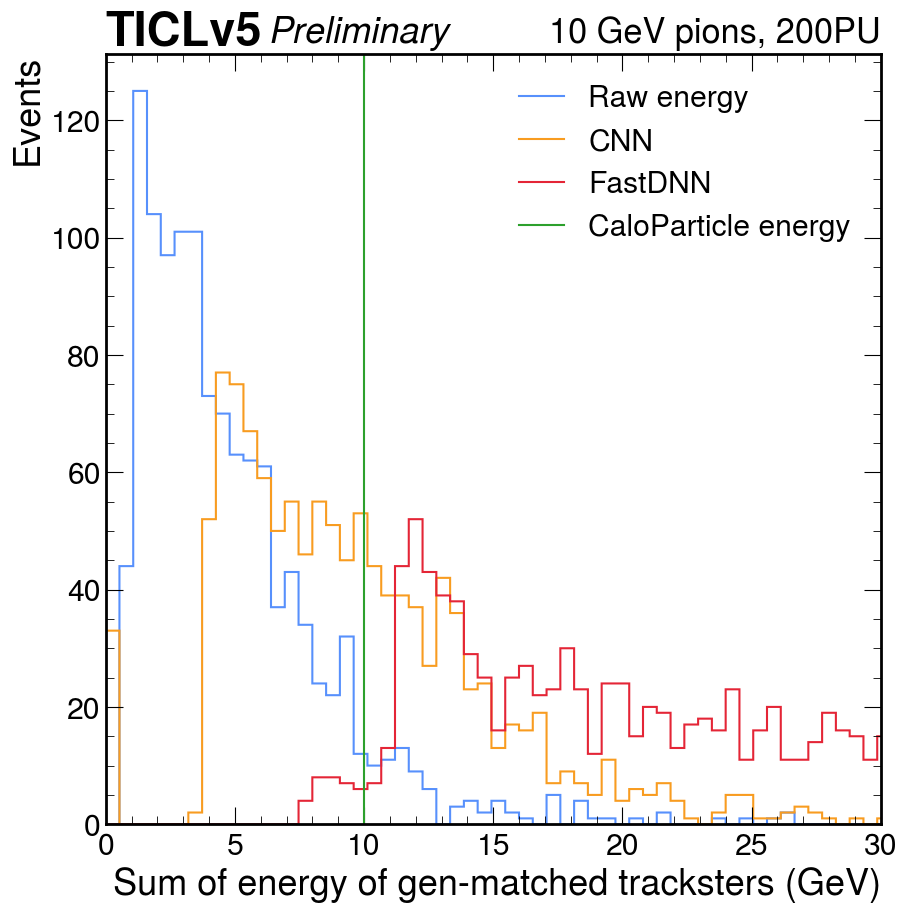

In [26]:
hists = hists_perE_PU_associated[10]
plt.figure()
rebin_cnt = 2
hep.histplot([hists["h_reco_tot"][::hist.rebin(rebin_cnt)], hists["h_cnn_tot"][::hist.rebin(rebin_cnt)], hists["h_pred_tot"][::hist.rebin(rebin_cnt)]],
    yerr=False, label=["Raw energy", "CNN", "FastDNN"], flow="none")

plt.axvline(x=10, label="CaloParticle energy", color="tab:green")

def plotFit(h:hist.Hist):
    fitRes = fitCruijff(h)
    params = fitRes.params
    x_plotFct = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1],500)
    plt.plot(x_plotFct,cruijff(x_plotFct,*params.makeTuple()), 
        label=f"Cruijff fit\n$\sigma={(params.sigmaL+params.sigmaR)/2:.3f}$, $\mu={params.m:.3f}$, " +r"$\frac{\sigma}{\mu}=" + f"{(params.sigmaL+params.sigmaR)/(2*params.m):.3f}$")

#plotFit(hists["h_pred_tot"][::hist.rebin(5)])

plt.ylabel("Events")
plt.xlabel("Sum of energy of gen-matched tracksters (GeV)")

plt.xlim(left=0, right=30)
plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("10 GeV pions, 200PU")

<Axes: xlabel='Sum of trackster energy in endcap (GeV)', ylabel='Events'>

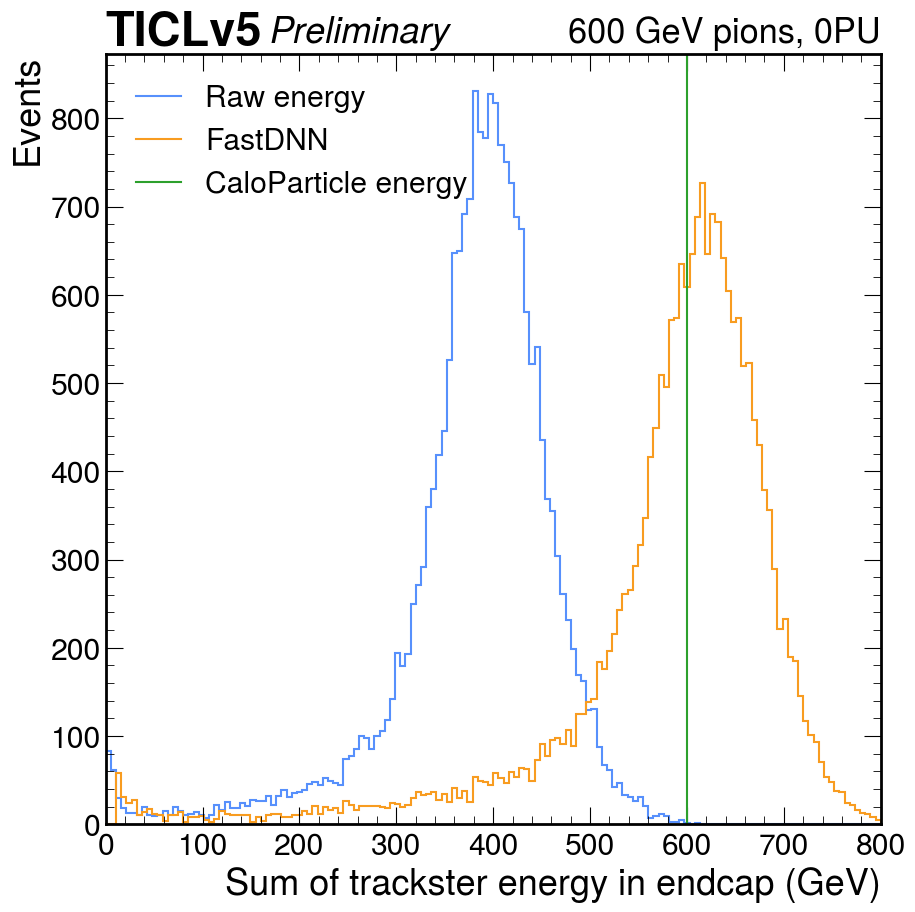

In [37]:
hists = hists_perE[600]
plt.figure()
rebin_cnt = 20
hep.histplot([hists["h_reco_tot"][::hist.rebin(rebin_cnt)], hists["h_pred_tot"][::hist.rebin(rebin_cnt)]],
    yerr=False, label=["Raw energy", "FastDNN"], flow="none")

plt.axvline(x=600, label="CaloParticle energy", color="tab:green")

def plotFit(h:hist.Hist):
    fitRes = fitCruijff(h)
    params = fitRes.params
    x_plotFct = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1],500)
    plt.plot(x_plotFct,cruijff(x_plotFct,*params.makeTuple()), 
        label=f"Cruijff fit\n$\sigma={(params.sigmaL+params.sigmaR)/2:.3f}$, $\mu={params.m:.3f}$, " +r"$\frac{\sigma}{\mu}=" + f"{(params.sigmaL+params.sigmaR)/(2*params.m):.3f}$")

#plotFit(hists["h_pred_tot"][::hist.rebin(5)])

plt.ylabel("Events")
plt.xlabel("Sum of trackster energy in endcap (GeV)")

plt.xlim(left=0, right=800)
plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("600 GeV pions, 0PU")

<Axes: xlabel='Sum of energy of gen-matched tracksters (GeV)', ylabel='Events'>

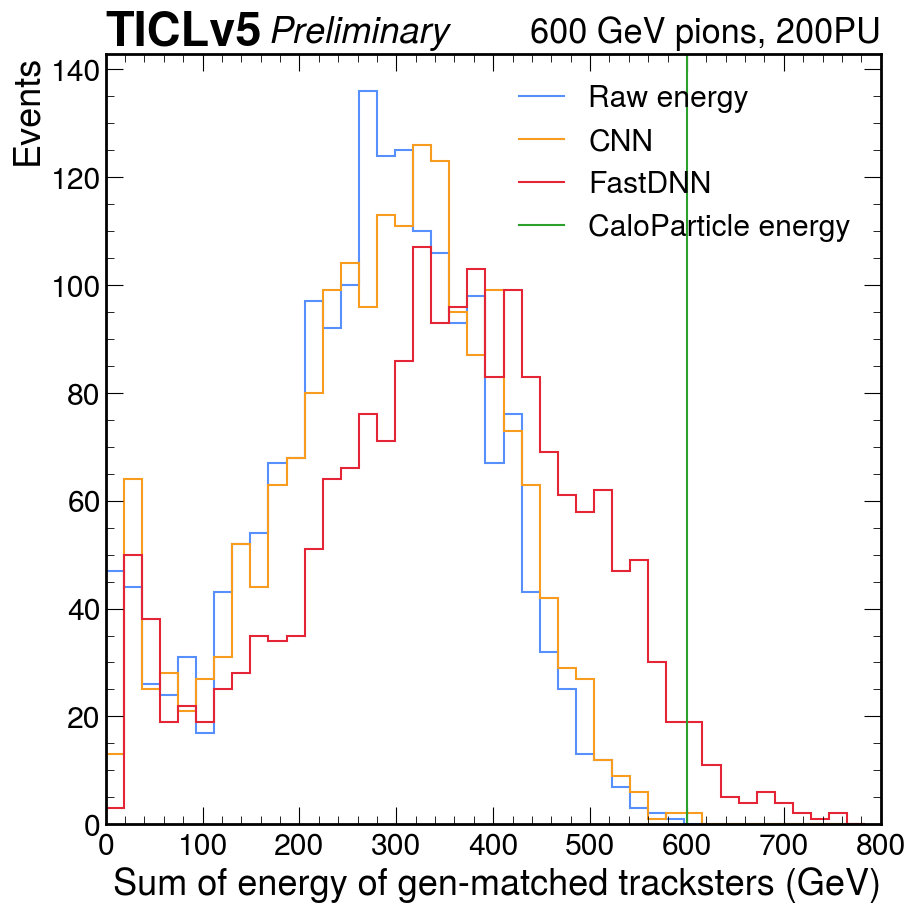

In [28]:
hists = hists_perE_PU_associated[600]
plt.figure()
rebin_cnt = 70
hep.histplot([hists["h_reco_tot"][::hist.rebin(rebin_cnt)], hists["h_cnn_tot"][::hist.rebin(rebin_cnt)], hists["h_pred_tot"][::hist.rebin(rebin_cnt)]],
    yerr=False, label=["Raw energy", "CNN", "FastDNN"], flow="none")

plt.axvline(x=600, label="CaloParticle energy", color="tab:green")

def plotFit(h:hist.Hist):
    fitRes = fitCruijff(h)
    params = fitRes.params
    x_plotFct = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1],500)
    plt.plot(x_plotFct,cruijff(x_plotFct,*params.makeTuple()), 
        label=f"Cruijff fit\n$\sigma={(params.sigmaL+params.sigmaR)/2:.3f}$, $\mu={params.m:.3f}$, " +r"$\frac{\sigma}{\mu}=" + f"{(params.sigmaL+params.sigmaR)/(2*params.m):.3f}$")

#plotFit(hists["h_pred_tot"][::hist.rebin(5)])

plt.ylabel("Events")
plt.xlabel("Sum of energy of gen-matched tracksters (GeV)")

plt.xlim(left=0, right=800)
plt.legend()
hep.cms.text("Preliminary", exp="TICLv5")
hep.cms.lumitext("600 GeV pions, 200PU")

## Resolution

In [29]:
fit_0PU = {key : {energy : fitCruijff(hists_atE[key]) for energy, hists_atE in hists_perE.items()} for key in [ "h_reco_tot_over_cp","h_cnn_tot_over_cp", "h_pred_tot_over_cp"]} 

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


<Axes: xlabel='Generated pion energy (GeV)', ylabel='$\\mu(\\frac{\\sum E_{trackster}}{E_{gen}})$'>

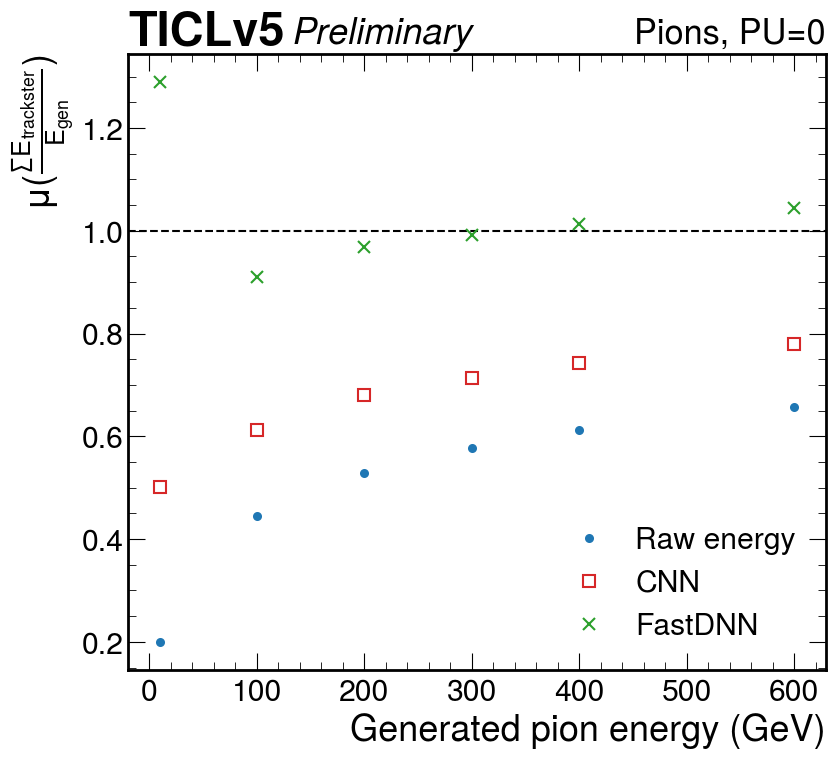

In [30]:
plotResolution(fit_0PU, legendLabel=dict(h_reco_tot_over_cp="Raw energy", h_cnn_tot_over_cp="CNN", h_pred_tot_over_cp="FastDNN"), plotMode="mu")
plt.axhline(y=1, color="black", ls="--")
hep.cms.lumitext("Pions, PU=0")

<Axes: xlabel='Generated pion energy (GeV)', ylabel='$\\mu(\\frac{\\sum E_{trackster}}{E_{gen}})$'>

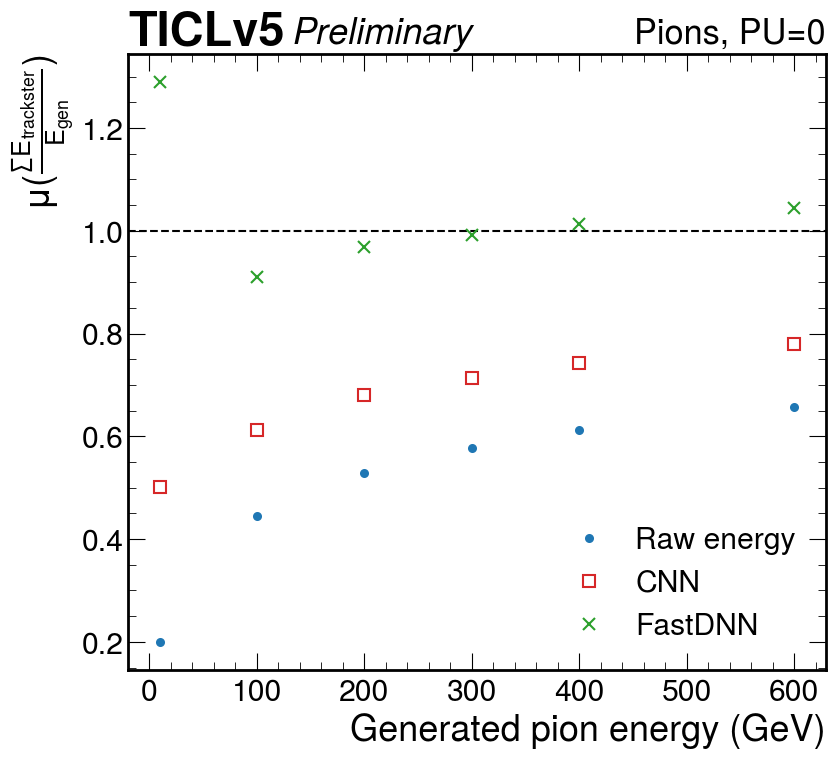

In [31]:
plotResolution(fit_0PU, legendLabel=dict(h_reco_tot_over_cp="Raw energy", h_cnn_tot_over_cp="CNN", h_pred_tot_over_cp="FastDNN"), plotMode="mu")
plt.axhline(y=1, color="black", ls="--")
hep.cms.lumitext("Pions, PU=0")

In [32]:
hists_perE_PU_associated

{10: {'h_pred': Hist(Regular(3000, 0, 800, name='pred_energy', label='fastDNN Predicted trackster energy (GeV)'), storage=Double()) # Sum: 1465.0,
  'h_reco': Hist(Regular(3000, 0, 800, name='reco_energy', label='Trackster raw energy (GeV)'), storage=Double()) # Sum: 1465.0,
  'h_cnn': Hist(Regular(3000, 0, 800, name='cnn_energy', label='Trackster regressed energy (Kate CNN) (GeV)'), storage=Double()) # Sum: 1465.0,
  'h_pred_vs_reco': Hist(
    Regular(200, 0, 800, name='reco_energy', label='Trackster raw energy (GeV)'),
    Regular(200, 0, 800, name='pred_energy', label='Predicted trackster energy (GeV)'),
    storage=Double()) # Sum: 1465.0,
  'h_pred_vs_reco_vs_cnn': Hist(
    Regular(200, 0, 800, name='reco_energy', label='Trackster raw energy (GeV)'),
    Regular(200, 0, 800, name='pred_energy', label='fastDNN trackster energy (GeV)'),
    Regular(400, 0, 800, name='cnn_energy', label='CNN Trackster regressed energy (Kate CNN) (GeV)'),
    storage=Double()) # Sum: 1465.0,
  'h_re

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/test/../../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 500000.

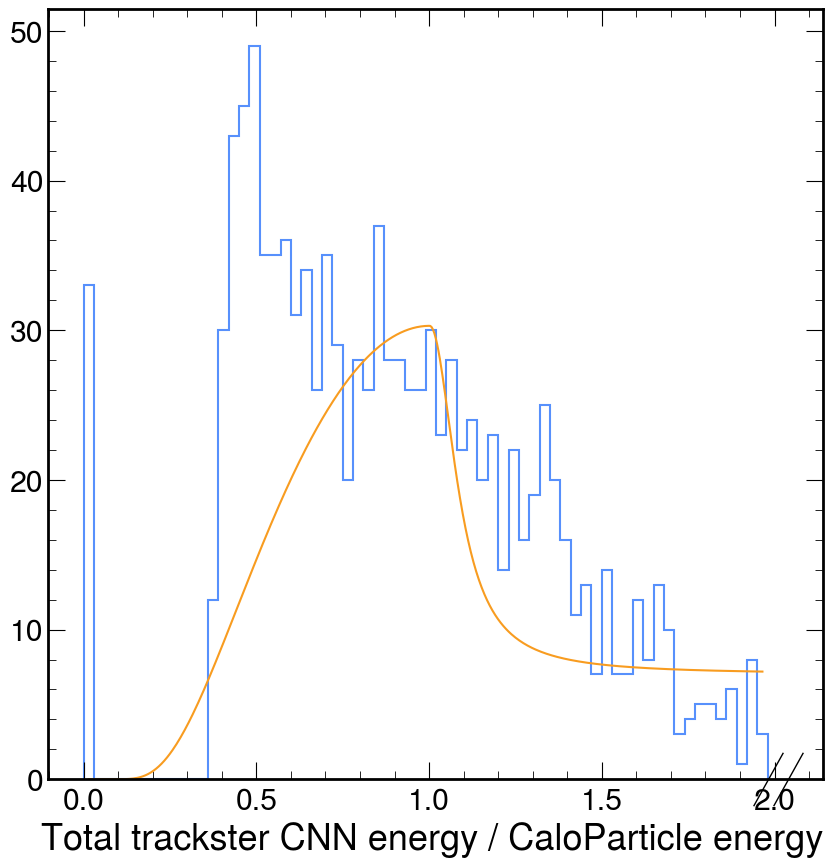

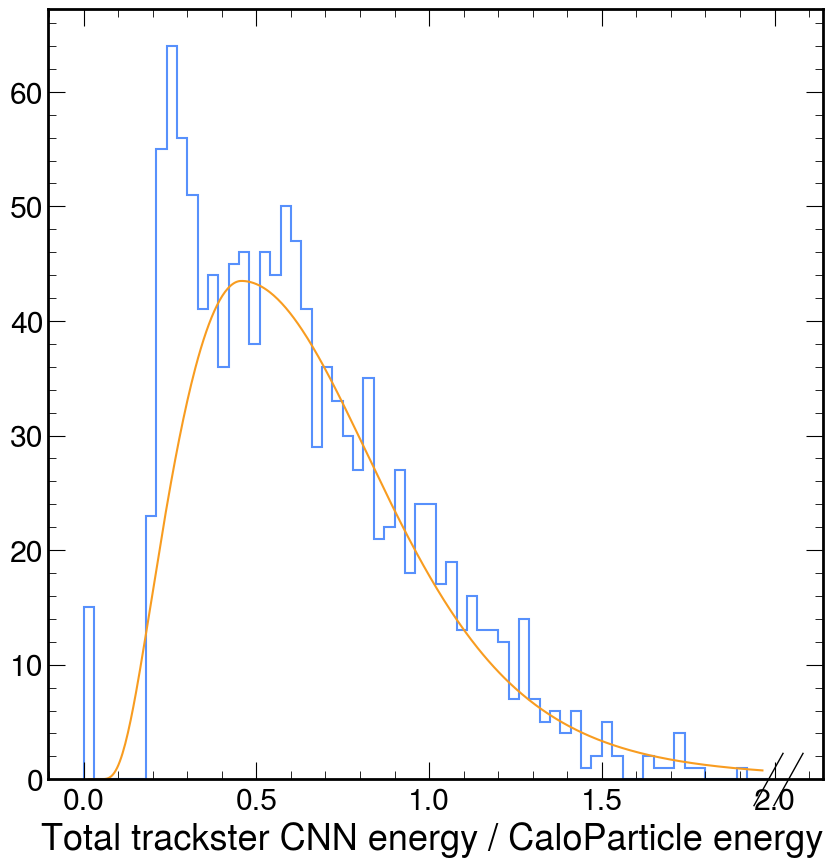

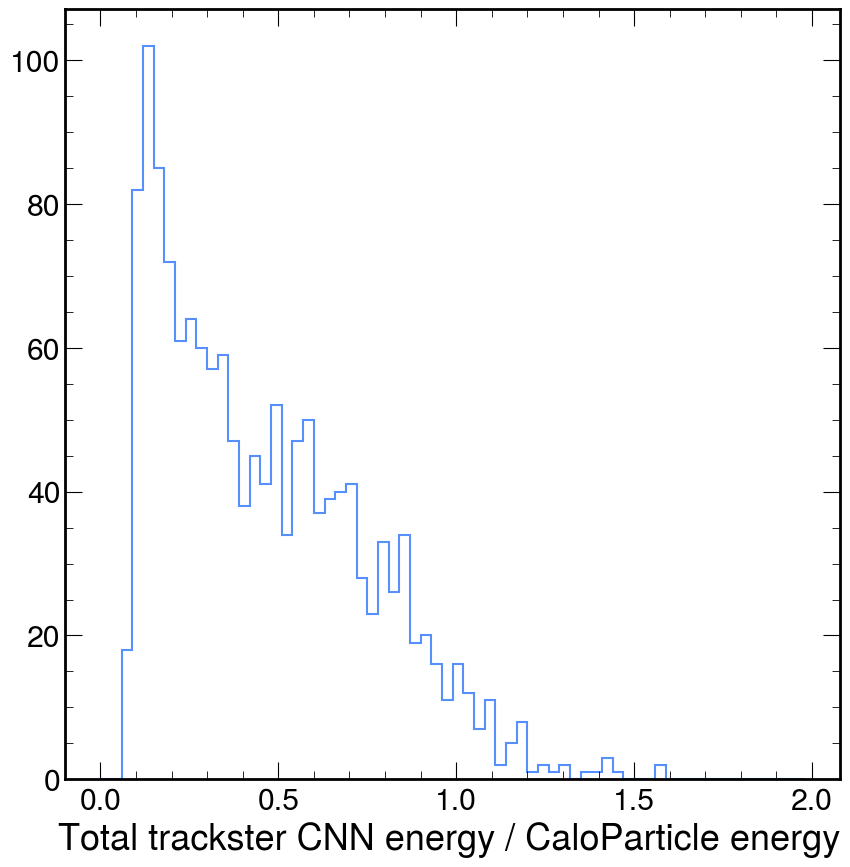

In [33]:
#"h_reco_tot_over_cp","h_cnn_tot_over_cp", "h_pred_tot_over_cp"
for energy, hists_atE in hists_perE_PU_associated.items():
    h_orig = hists_atE["h_cnn_tot_over_cp"]
    h = h_orig[::hist.rebin(3)]
    plt.figure()
    hep.histplot(h, yerr=False)
    fitRes = fitCruijff(h)
    params = fitRes.params
    x_plotFct = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1],500)
    plt.plot(x_plotFct,cruijff(x_plotFct,*params.makeTuple()), 
        label=f"Cruijff fit\n$\sigma={(params.sigmaL+params.sigmaR)/2:.3f}$, $\mu={params.m:.3f}$, " +r"$\frac{\sigma}{\mu}=" + f"{(params.sigmaL+params.sigmaR)/(2*params.m):.3f}$")

In [ ]:
fit_200PU = {key : {energy : fitCruijff(hists_atE[key]) for energy, hists_atE in hists_perE_PU_associated.items()} for key in [ "h_reco_tot_over_cp","h_cnn_tot_over_cp", "h_pred_tot_over_cp"]} 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 500000.

In [ ]:
fit_200PU = {key : {energy : fitCruijff(hists_atE[key]) for energy, hists_atE in hists_perE_PU_associated.items()} for key in [ "h_reco_tot_over_cp","h_cnn_tot_over_cp", "h_pred_tot_over_cp"]} 